In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

import numpy as np
from analysis import collection, analysis, emg, plot, model
import scipy as sp
from pathlib import Path

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

import matplotlib.pyplot as plt

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

In [3]:
subject_idx = 9

- look at GMM model covariances for one subject
- look at PCA results for the same log data used to fit the model -- sum of rank-1 covariance (comp @ comp.T)

In [4]:
models = model.load_log_trial_models(subject_idx)

In [5]:
first_model = models[0]

In [6]:
stack = analysis.load_trial_stack(subject_idx=subject_idx)

In [7]:
sessions = stack[:9]

In [8]:
with_nans = sessions.transpose(0,1,3,2).reshape(-1,64)
print(with_nans.shape)
samples = analysis.remove_nan_rows(with_nans)
print(samples.shape)

(216000, 64)
(51397, 64)


### PCA on log samples

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(analysis.log_emg_data(samples))
pca_comps = pca.components_
pca_covs = np.array([c.reshape(-1,1) @ c.reshape(1,-1) for c in pca_comps])
print(pca_covs.shape)

(64, 64, 64)


In [10]:
model_covs = first_model.covariances_
model_covs.shape

(12, 64, 64)

In [11]:
weight_order = np.argsort(first_model.weights_)[::-1]
weight_order

array([ 8,  5,  0,  7, 10,  2,  1,  6, 11,  4,  3,  9])

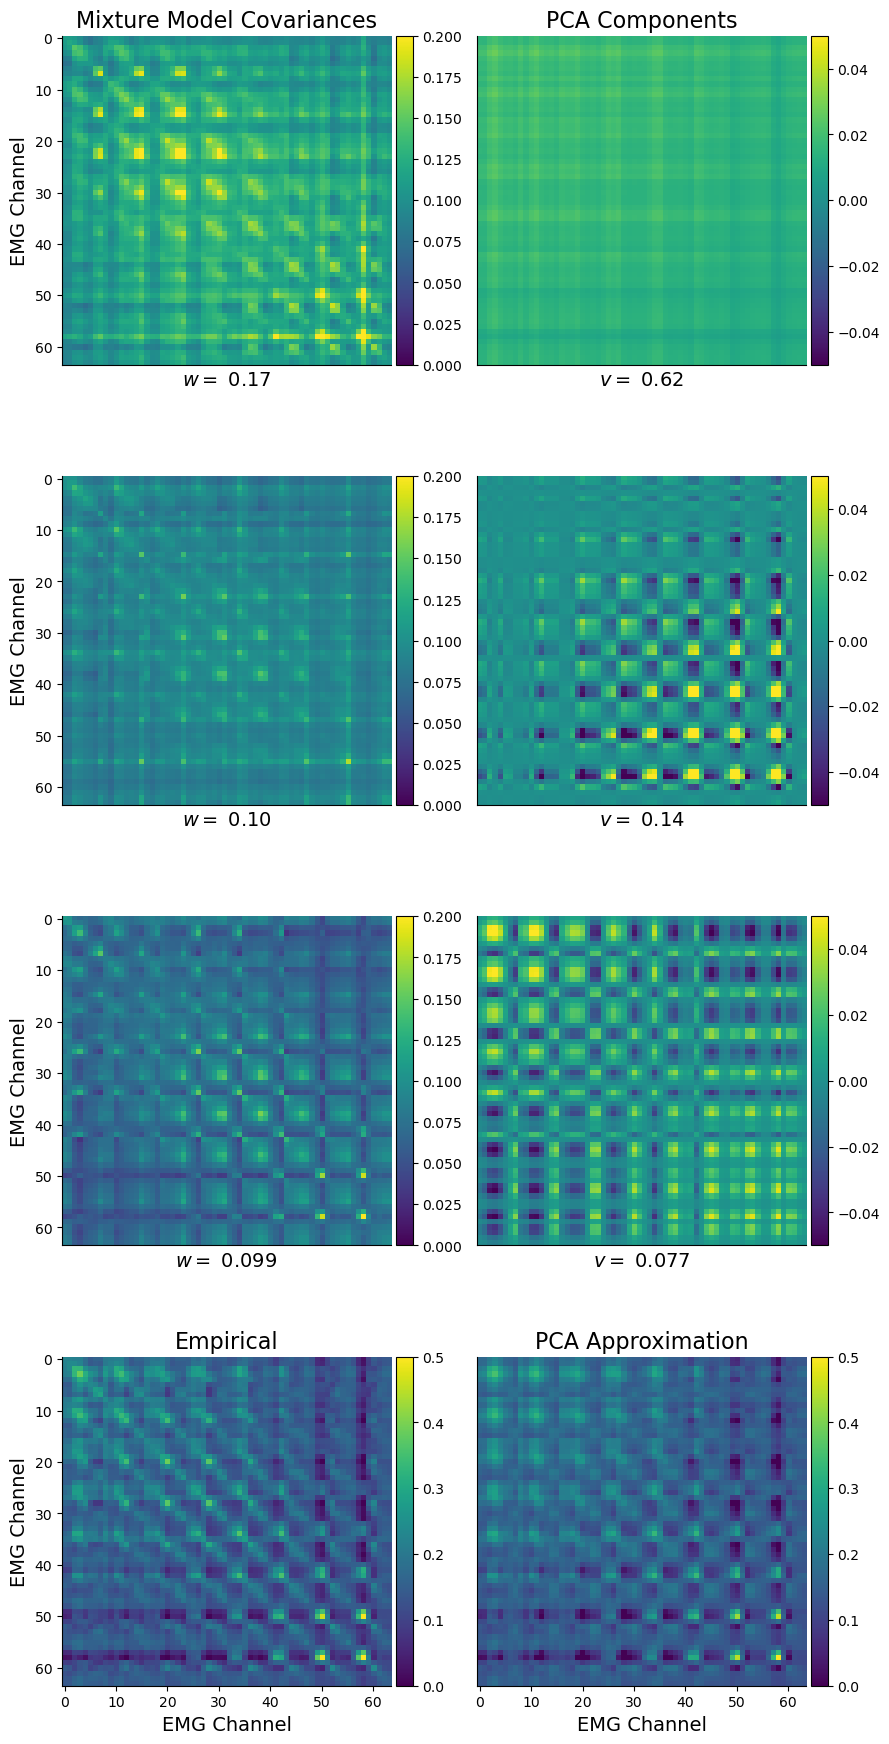

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

pca_fig, axes = plt.subplots(4,2,figsize=(9,18))

sum = np.zeros_like(model_covs[0])
for axi, i in enumerate(weight_order[:3]):
    axes[axi,0].set_ylabel("EMG Channel",fontsize=14)
    h = axes[axi,0].imshow(model_covs[i],vmin=0,vmax=0.2)
    divider = make_axes_locatable(axes[axi,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pca_fig.colorbar(h,cax=cax)
    sum += model_covs[i]*first_model.weights_[i]
    axes[axi,0].set_xlabel(f"$w = $ {plot.format_positional(first_model.weights_[i])}",fontsize=14)
    axes[axi,0].set_xticks([])
axes[0,0].set_title("Mixture Model Covariances",fontsize=16)
h = axes[-1,0].imshow(np.cov(analysis.log_emg_data(samples).T),vmin=0,vmax=0.5)
divider = make_axes_locatable(axes[-1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
pca_fig.colorbar(h,cax=cax)
axes[-1,0].set_title("Empirical",fontsize=16)
axes[-1,0].set_xlabel("EMG Channel",fontsize=14)
axes[-1,0].set_ylabel("EMG Channel",fontsize=14)

sum = np.zeros_like(pca_covs[0])
for i in range(64):
    if i < 3:
        h = axes[i,1].imshow(pca_covs[i],vmin=-0.05,vmax=0.05)
        sum += pca_covs[i]*pca.explained_variance_[i]
        axes[i,1].set_xlabel(f"$v = $ {plot.format_positional(pca.explained_variance_ratio_[i])}",fontsize=14)
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        divider = make_axes_locatable(axes[i,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        pca_fig.colorbar(h,cax=cax)
axes[0,1].set_title("PCA Components",fontsize=16)
h = axes[-1,1].imshow(sum,vmin=0,vmax=0.5)
divider = make_axes_locatable(axes[-1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
pca_fig.colorbar(h,cax=cax)
axes[-1,1].set_title("PCA Approximation",fontsize=16)
axes[-1,1].set_xlabel("EMG Channel",fontsize=14)
axes[-1,1].set_yticks([])

pca_fig.tight_layout()

In [38]:
plot.save_figure(pca_fig, "gmm_vs_pca",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/gmm_vs_pca.pdf
